['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


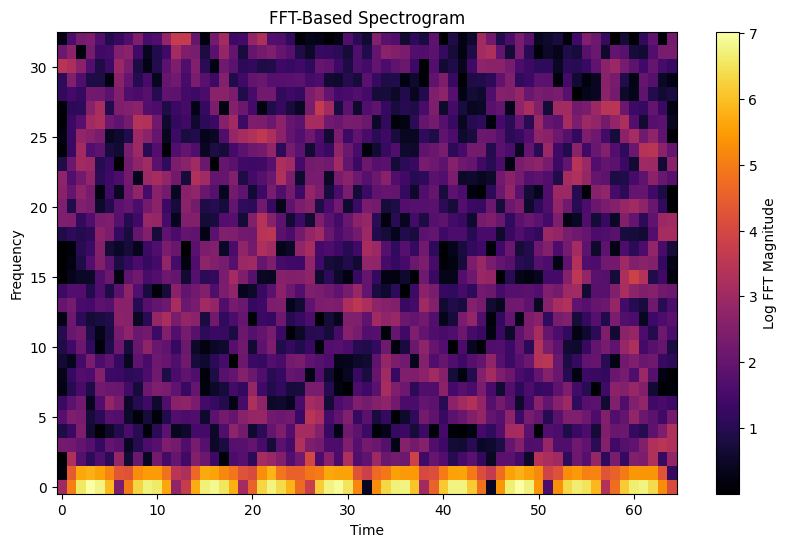

7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
10
14
22
38
70
134
261
515


/opt/anaconda3/envs/ece247/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 33 is too high: all coefficients will experience boundary effects.
  warnings.warn(


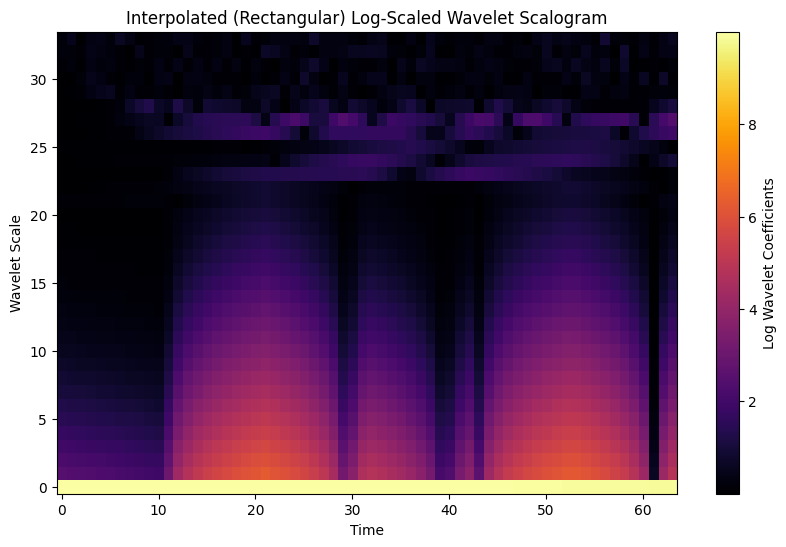

Scalogram shape: torch.Size([34, 515])


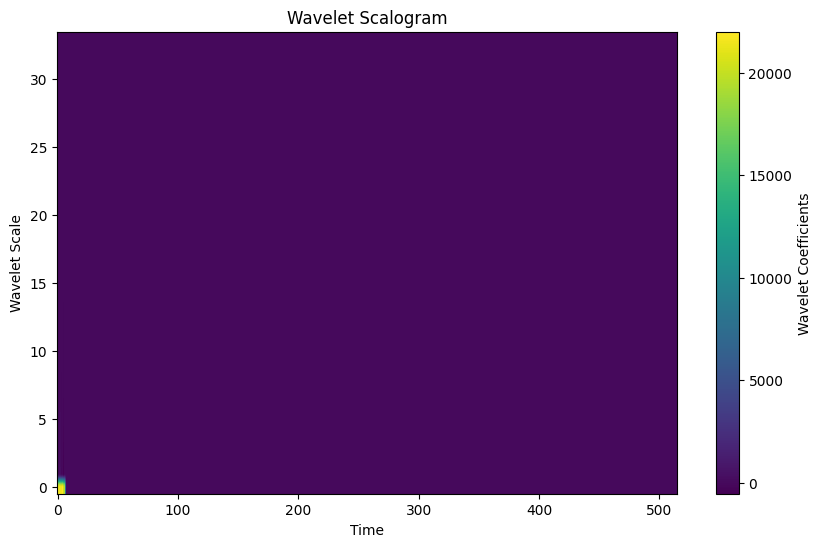

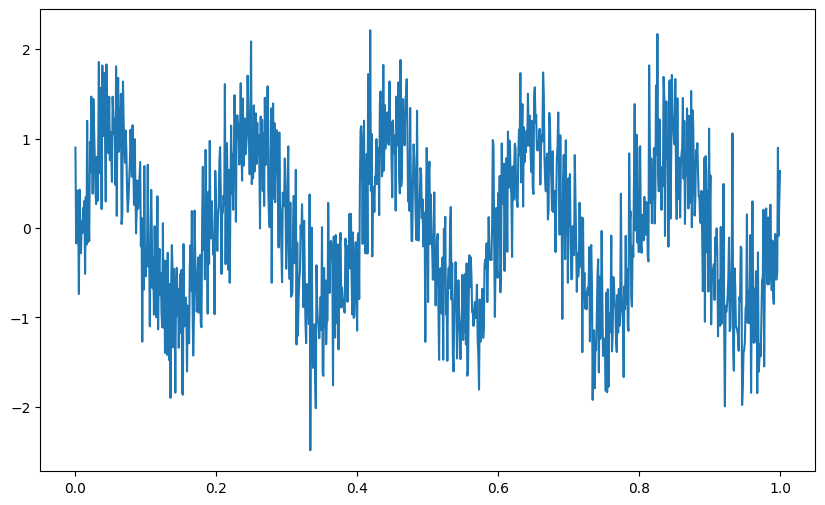

In [ ]:
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
import pywt
import numpy as np
import matplotlib.pyplot as plt

print(pywt.wavelist(kind='discrete'))

# Generate sample time-domain signal (sine wave + noise)
N = 1024  # Number of time samples
t = torch.linspace(0, 1, N)
signal = torch.sin(2 * torch.pi * 5 * t) + 0.5 * torch.randn(N)

# Apply Short-Time Fourier Transform (STFT)
n_fft = 64  # FFT window size
hop_length = n_fft // 4  # Overlap (higher resolution)
spectrogram_transform = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
spectrogram = spectrogram_transform(signal.unsqueeze(0))  # Add batch dimension

# Convert to log scale for visualization
spectrogram_log = torch.log1p(spectrogram.squeeze())

# Plot FFT Spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(spectrogram_log.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.colorbar(label="Log FFT Magnitude")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("FFT-Based Spectrogram")
plt.show()

# Choose a wavelet
wavelet = 'db4'  # Morlet wavelet (good for scalograms)

# Perform DWT with multiple levels
num_levels = 33  # Number of wavelet scales
coeffs = pywt.wavedec(signal.numpy(), wavelet, level=num_levels)
# Normalize and interpolate each level to full size
scalogram_list = []
for c in coeffs:
    print(f'{len(c)}')
    c_tensor = torch.tensor(c).unsqueeze(0).unsqueeze(0)  # Shape (1,1,L)
    c_resized = F.interpolate(c_tensor, size=(N//16,), mode="linear", align_corners=True)  # Upsample to N
    scalogram_list.append(c_resized.squeeze())

# Stack into a proper scalogram
scalogram_rect = torch.stack(scalogram_list)

# Convert to log scale
scalogram_log = torch.log1p(torch.abs(scalogram_rect))
print(f'Scalogram shape: {scalogram_log.shape}')

# Plot the log-scaled wavelet scalogram (now rectangular)
plt.figure(figsize=(10, 6))
plt.imshow(scalogram_log.numpy(), aspect='auto', cmap='inferno', origin='lower')
plt.colorbar(label="Log Wavelet Coefficients")
plt.xlabel("Time")
plt.ylabel("Wavelet Scale")
plt.title("Interpolated (Rectangular) Log-Scaled Wavelet Scalogram")
plt.show()

# Normalize and stack wavelet coefficients into a 2D array
max_len = max(len(c) for c in coeffs)  # Longest coefficient array

# Pad shorter coefficient arrays to match the longest one
coeffs_padded = [F.pad(torch.tensor(c), (0, max_len - len(c)), "constant", 0) for c in coeffs]

# Stack coefficients as a 2D tensor (wavelet scalogram)
scalogram = torch.stack(coeffs_padded)  # Shape: (num_levels, max_len)

print(f"Scalogram shape: {scalogram.shape}")  # (num_levels, time_steps)

# Plot the scalogram
plt.figure(figsize=(10, 6))
plt.imshow(scalogram.numpy(), aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label="Wavelet Coefficients")
plt.xlabel("Time")
plt.ylabel("Wavelet Scale")
plt.title("Wavelet Scalogram")
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(t, signal)
plt.show()